# Coursera / IBM Data Science Professional Certificate - Capstone Project
## Week 3
### This project is utilized for the Coursera IBM Data Science Capstone Project. The project will focus on the use-case of using location data to determine neighborhoods in a different side of the city of Toronto, Canada.

# Transform the list of Toronto Postal Codes Data into a pandas dataframe from the Wikipedia website page.

In [1]:
# Import libraries
import numpy as np

import pandas as pd
from pandas.io.json import json_normalize # Transforming json file into a pandas dataframe library

import requests

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!pip install bs4
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # Convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # Map rendering library

print('Libraries imported.')

Libraries imported.


### Beautiful Soup Processing

In [2]:
# URL Processing
wiki_url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050'
html_data = requests.get(wiki_url).text

# Create beautifulsoup4 object
toronto_soup = BeautifulSoup(html_data,"html5lib")

# Select table based on class type
toronto_table = toronto_soup.find('table', class_='wikitable sortable')

# Create Empty list for each column
col_1 = [] # Postcode
col_2 = [] # Borough
col_3 = [] # Neighbourhood

# For loop - Append cell values in each column
for row in toronto_table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) == 3: # scraped table have 3 columns
        col_1.append(cells[0].find(text=True))
        col_2.append(cells[1].find(text=True))
        col_3.append(cells[2].find(text=True))

### Convert and combine HTML data lists

In [3]:
# Combine all three lists
wiki_raw_df = pd.DataFrame(list(zip(col_1, col_2, col_3)), columns = ['Postal Code', 'Borough', 'Neighborhood'])
print("Raw dataframe shape: {}".format(wiki_raw_df.shape))
print(type(wiki_raw_df))
print(wiki_raw_df.head())

Raw dataframe shape: (287, 3)
<class 'pandas.core.frame.DataFrame'>
  Postal Code           Borough      Neighborhood
0         M1A      Not assigned    Not assigned\n
1         M2A      Not assigned    Not assigned\n
2         M3A        North York         Parkwoods
3         M4A        North York  Victoria Village
4         M5A  Downtown Toronto      Harbourfront


### Pre-processing

In [4]:
# Remove extra string characters "\n" from preprocess dataframe
wiki_pre_df_1 = wiki_raw_df.replace('\n','', regex=True)

# Preprocess dataframe shape 1
print("Preprocess dataframe shape 1: {}".format(wiki_pre_df_1.shape))

# Space
print()

# New dataframe subset 1 - Drop "Not Assigned" Boroughs
wiki_pre_df_1 = wiki_pre_df_1[wiki_pre_df_1['Borough'] != 'Not assigned']

# Verify if there are any "Not assigned" elements in the "Neighborhood" column
print(wiki_pre_df_1[wiki_pre_df_1['Neighborhood'] == 'Not assigned'])
print(wiki_pre_df_1['Neighborhood'].value_counts())

Preprocess dataframe shape 1: (287, 3)

Empty DataFrame
Columns: [Postal Code, Borough, Neighborhood]
Index: []
Runnymede            2
St. James Town       2
Parkdale Village     1
Kensington Market    1
Milliken             1
                    ..
West Deane Park      1
Parkwoods            1
CFB Toronto          1
Queen's Park         1
Silverstone          1
Name: Neighborhood, Length: 208, dtype: int64


In [5]:
# New dataframe subset 2 - Combine neighborhoods belonging to respective boroughs
wiki_pre_df_2 = wiki_pre_df_1.groupby(['Postal Code', 'Borough']).apply(lambda group: ','.join(group['Neighborhood'])).to_frame()

# preprocess dataframe shape 2
print("Preprocessing dataframe shape 2: {}".format(wiki_pre_df_2.shape))

# Verify preprocessing status
print(type(wiki_pre_df_2))
wiki_pre_df_2

# Space
print()

# New dataframe subset 3 - Assign to new dataframe
wiki_pre_df_3 = wiki_pre_df_2
wiki_pre_df_3.reset_index(inplace=True)
wiki_pre_df_3.columns.values[2] = 'Neighborhood' # Rename third column
print("Preprocessing dataframe shape 3: {}".format(wiki_pre_df_3.shape))
print(type(wiki_pre_df_3))

# Space
print()

wiki_pre_df_3.head()

Preprocessing dataframe shape 2: (103, 1)
<class 'pandas.core.frame.DataFrame'>

Preprocessing dataframe shape 3: (103, 3)
<class 'pandas.core.frame.DataFrame'>



,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
# Pre-processing dataframe
# wiki_pre_df_3.shape
print("Current dataframe shape: {}".format(wiki_pre_df_3.shape))

Current dataframe shape: (103, 3)


<hr style="border:2px solid gray"> </hr>

# Create a pandas dataframe from the list of Toronto Postal Codes Data and from the Geospatial_Coordinates.csv file.

### Upload longitude and latitude data

In [7]:
# New dataframe subset 4 - Assign to new dataframe
wiki_df = wiki_pre_df_3

# Upload/Read Geospatial_Coordinates.csv file
postcode_coord = pd.read_csv('Geospatial_Coordinates.csv')

print("Wikipedia data shape: {}".format(wiki_df.shape))
print(type(wiki_df))
print(wiki_df.head())
print()
print("Geospatial data shape: {}".format(postcode_coord.shape))
print(type(postcode_coord))
print(postcode_coord.head())

Wikipedia data shape: (103, 3)
<class 'pandas.core.frame.DataFrame'>
  Postal Code      Borough                          Neighborhood
0         M1B  Scarborough                         Rouge,Malvern
1         M1C  Scarborough  Highland Creek,Rouge Hill,Port Union
2         M1E  Scarborough       Guildwood,Morningside,West Hill
3         M1G  Scarborough                                Woburn
4         M1H  Scarborough                             Cedarbrae

Geospatial data shape: (103, 3)
<class 'pandas.core.frame.DataFrame'>
  Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476


### Merge HTML dataframe and Coordinates dataframe

In [8]:
# New dataframe - Merge Wikipedia table and Coordinates table together
wiki_coord_merge = pd.merge(wiki_df, postcode_coord, on='Postal Code')
print("Merged dataframe shape: {}".format(wiki_coord_merge.shape))
print(type(wiki_coord_merge))

# Space
print()

wiki_coord_merge.head()

Merged dataframe shape: (103, 5)
<class 'pandas.core.frame.DataFrame'>



,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<hr style="border:2px solid gray"> </hr>

# Explore and cluster the Toronto neighborhoods.

### NOTE: The assessment and analysis done below is only in the preliminary stage. More information is required for a thorough assessment of the project.

### Select boroughs that have "Toronto" only

In [9]:
# New dataframe - Select boroughs that have "Toronto" in each element
toronto_area = wiki_coord_merge[wiki_coord_merge['Borough'].str.contains('Toronto', na=False)]
print("Toronto dataframe shape: {}".format(toronto_area.shape))
print(type(toronto_area))

# Space
print()

toronto_area.head()

Toronto dataframe shape: (39, 5)
<class 'pandas.core.frame.DataFrame'>



,Postal Code,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### Choose appropriate number of clusters based on coordinates data

C:\anaconda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'Inertia')

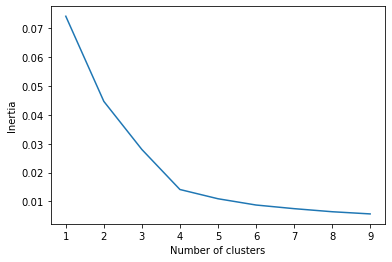

In [10]:
choose_k = toronto_area.drop(['Postal Code', 'Borough', 'Neighborhood'], 1)

inertias = []
 
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(choose_k)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 10), inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

### KMeans Processing

### NOTE: toronto_cluster's index will be reset in the following cells 

In [11]:
# Create new dataframe
toronto_cluster = toronto_area
print("New Toronto dataframe shape: {}".format(toronto_cluster.shape))
print(type(toronto_cluster))

# KMeans clustering
k = 4 # Manually set from above 
toronto_clustering = toronto_cluster.drop(['Postal Code', 'Borough', 'Neighborhood'], 1)
kmeans = KMeans(n_clusters = k, random_state = 0).fit(toronto_clustering)
# kmeans.labels_

# New dataframe - Create new dataframe to include cluster label
toronto_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

# Space
print()

toronto_cluster

New Toronto dataframe shape: (39, 5)
<class 'pandas.core.frame.DataFrame'>



,Cluster Labels,Postal Code,Borough,Neighborhood,Latitude,Longitude
37,3,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,3,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
42,3,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
43,3,M4M,East Toronto,Studio District,43.659526,-79.340923
44,2,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,2,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,2,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,2,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160
49,2,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049


### Visualize Clustered Neighborhoods

In [12]:
# Example: map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=10)
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [13]:
# Verify variables chosen
print('Chosen latitude variable: {}'.format(latitude))
print('Chosen longitude variable: {}'.format(longitude))
print('Chosen k cluster variable: {}'.format(k))

Chosen latitude variable: 43.6534817
Chosen longitude variable: -79.3839347
Chosen k cluster variable: 4


##### NOTE: The marker colors may be to light to see. There are four cluster markers in the folium map below.

In [14]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
kclusters = k # Manually set from above
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 0.5, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_cluster['Latitude'], toronto_cluster['Longitude'], toronto_cluster['Neighborhood'], toronto_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Pre-Analysis - Select one neighborhood

##### Investigate a neighborhood in Central Toronto - Lawrence Park

In [15]:
# Foursquare API
CLIENT_ID = 'YNA4BWHRXA31H5DSRN2ATW54UWJEDLAAIHWFGO2YUKBL0YBQ' # your Foursquare ID
CLIENT_SECRET = 'IEZKA1REZRJLYDMZM2H1Q4KJ2OYCEWU4BVA0YLOL534VIUBI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # 100 - Default Foursquare API limit value

In [16]:
# Chosen Neighborhood in Central Toronto Borough
toronto_neighborhood = toronto_cluster
toronto_neighborhood.reset_index(inplace=True) # Reset index from previous query

# Specify coordinates
neighborhood_latitude = toronto_neighborhood.loc[4, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_neighborhood.loc[4, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_neighborhood.loc[4, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Lawrence Park are 43.7280205, -79.3887901.


##### Query for any Thai restaurants within a 100-mile radius

In [17]:
search_query = 'Thai'
radius = 100
print(search_query + ' .... OK!')

Thai .... OK!


In [18]:
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # Display URL

'https://api.foursquare.com/v2/venues/search?&client_id=YNA4BWHRXA31H5DSRN2ATW54UWJEDLAAIHWFGO2YUKBL0YBQ&client_secret=IEZKA1REZRJLYDMZM2H1Q4KJ2OYCEWU4BVA0YLOL534VIUBI&v=20180605&ll=43.7280205,-79.3887901&radius=100&limit=50'

In [19]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60a120b5df719f70b3aed4d1'},
 'response': {'venues': [{'id': '4b34e56ef964a520052925e3',
    'name': 'Toronto French School',
    'location': {'address': '306 Lawrence Ave East',
     'crossStreet': 'Bayview Ave',
     'lat': 43.728554,
     'lng': -79.385325,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.728554,
       'lng': -79.385325}],
     'distance': 284,
     'postalCode': 'M4N 1T7',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['306 Lawrence Ave East (Bayview Ave)',
      'Toronto ON M4N 1T7',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d13d941735',
      'name': 'High School',
      'pluralName': 'High Schools',
      'shortName': 'High School',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/school_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1621172405',
    'hasPerk': False},
   {'id': 

In [20]:
# Code within this is cell is from lesson - Mofied as needed
# Sssign relevant part of JSON to venues
venues = results['response']['venues']

# Transform venues into a dataframe
# dataframe = json_normalize(venues)
dataframe = pd.json_normalize(venues)
dataframe.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood,venuePage.id
0,4b34e56ef964a520052925e3,Toronto French School,"[{'id': '4bf58dd8d48988d13d941735', 'name': 'H...",v-1621172405,False,306 Lawrence Ave East,Bayview Ave,43.728554,-79.385325,"[{'label': 'display', 'lat': 43.728554, 'lng':...",284,M4N 1T7,CA,Toronto,ON,Canada,"[306 Lawrence Ave East (Bayview Ave), Toronto ...",NaN,NaN
1,50ed9da8e4b081eabee12672,TTC Bus #162 - Lawrence-Donway,"[{'id': '4bf58dd8d48988d12b951735', 'name': 'B...",v-1621172405,False,NaN,NaN,43.728026,-79.382805,"[{'label': 'display', 'lat': 43.72802605799448...",481,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,NaN
2,4c8ce51b5e048cfab4a0d0cd,Withrow Avenue Public School,"[{'id': '4f4533804b9074f6e4fb0105', 'name': 'E...",v-1621172405,False,NaN,NaN,43.670647,-79.351448,"[{'label': 'display', 'lat': 43.67064721272852...",7058,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,NaN
3,5efd06dd25dda60008bf3f32,cheltenham park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1621172405,False,NaN,NaN,43.726670,-79.385324,"[{'label': 'display', 'lat': 43.72667, 'lng': ...",316,M4N 3G7,CA,Toronto,ON,Canada,"[Toronto ON M4N 3G7, Canada]",NaN,NaN
4,4bc3e7b3461576b0455d7f32,Gallery Towers,[],v-1621172405,False,NaN,NaN,43.733410,-79.393610,"[{'label': 'display', 'lat': 43.73341, 'lng': ...",714,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,NaN


In [21]:
# Code within this is cell is from lesson - Mofied as needed
# Keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# Clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Toronto French School,High School,306 Lawrence Ave East,Bayview Ave,43.728554,-79.385325,"[{'label': 'display', 'lat': 43.728554, 'lng':...",284,M4N 1T7,CA,Toronto,ON,Canada,"[306 Lawrence Ave East (Bayview Ave), Toronto ...",NaN,4b34e56ef964a520052925e3
1,TTC Bus #162 - Lawrence-Donway,Bus Line,NaN,NaN,43.728026,-79.382805,"[{'label': 'display', 'lat': 43.72802605799448...",481,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,50ed9da8e4b081eabee12672
2,Withrow Avenue Public School,Elementary School,NaN,NaN,43.670647,-79.351448,"[{'label': 'display', 'lat': 43.67064721272852...",7058,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,4c8ce51b5e048cfab4a0d0cd
3,cheltenham park,Park,NaN,NaN,43.726670,-79.385324,"[{'label': 'display', 'lat': 43.72667, 'lng': ...",316,M4N 3G7,CA,Toronto,ON,Canada,"[Toronto ON M4N 3G7, Canada]",NaN,5efd06dd25dda60008bf3f32
4,Gallery Towers,None,NaN,NaN,43.733410,-79.393610,"[{'label': 'display', 'lat': 43.73341, 'lng': ...",714,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,4bc3e7b3461576b0455d7f32


##### Query for any restaurants in subset dataframe

In [22]:
# Check values in the "categories" column
dataframe_filtered['categories'].value_counts()

Bus Line                     3
High School                  2
College Academic Building    2
Church                       2
Prayer Room                  1
University                   1
Bank                         1
Fast Food Restaurant         1
Café                         1
College Theater              1
Bus Stop                     1
Parking                      1
Medical Center               1
Building                     1
Lake                         1
Pharmacy                     1
Bakery                       1
Office                       1
Trail                        1
Elementary School            1
Design Studio                1
College Auditorium           1
Swim School                  1
Sushi Restaurant             1
Badminton Court              1
Park                         1
Name: categories, dtype: int64

##### Result indicates that the elements in the "categories" column have empty values

In [23]:
# Check "None" values in the "categories" column
dataframe_filtered[dataframe_filtered['categories'] == 'None']

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id


##### There seems to be only a few food restaurants available ... Need more data

In [24]:
# Check the name value of the fast food restaurant
restaurant = dataframe_filtered[dataframe_filtered['categories'] == 'Fast Food Restaurant']
restaurant['name']

13    Italian Cafe
Name: name, dtype: object

In [25]:
# Check the name value of the cafe
restaurant_2 = dataframe_filtered[dataframe_filtered['categories'] == 'Café']
restaurant_2['name']

47    Granite Club President's Lounge
Name: name, dtype: object

In [26]:
# Check the name value of the bakery
restaurant_3 = dataframe_filtered[dataframe_filtered['categories'] == 'Bakery']
restaurant_3['name']

36    Robyn's Cookies
Name: name, dtype: object

In [27]:
# Check the name value of the sushi restaurant
restaurant_4 = dataframe_filtered[dataframe_filtered['categories'] == 'Sushi Restaurant']
restaurant_4['name']

44    Wakame Sushi
Name: name, dtype: object

##### Visualize queried food restaurants in Lawrence Park Neighborhood

In [28]:
# Code within this is cell is from lesson - Mofied as needed
venues_map = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# Add a red circle marker to represent the Lawrence Park Neighborhood
folium.CircleMarker(
    [neighborhood_latitude, neighborhood_longitude],
    radius=10,
    color='red',
    popup='Lawrence Park Neighborhood',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# Add the Italian Restaurant as a blue circle marker
for lat, lng, label in zip(restaurant.lat, restaurant.lng, restaurant.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# Add the cafe as a blue circle marker
for lat, lng, label in zip(restaurant_2.lat, restaurant_2.lng, restaurant_2.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)    

# Add the bakery as a blue circle marker
for lat, lng, label in zip(restaurant_3.lat, restaurant_3.lng, restaurant_3.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# Add the sushi restaurant as a blue circle marker
for lat, lng, label in zip(restaurant_4.lat, restaurant_4.lng, restaurant_4.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# Display map
venues_map

### NOTE: The assessment and analysis done above is only in the preliminary stage. More information is required for a thorough assessment of the project.